In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

#Graph libraries
from sklearn import metrics
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model + Training libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model 

# Time
import time
import datetime

2025-07-01 15:39:56.122079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751384396.312693      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751384396.363158      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
# date_time function
def date_time(x):
    if x == 1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x == 2:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x == 3:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x == 4:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    
# Performance plot
def performance_plot(history = None, figure_directory = None, ylim_pad = [0,0]):
    xlabel = 'Epochs'
    legend = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))
    
    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']
    
    min_y = min(min(y1), min(y2)) - ylim_pad[0]
    max_y = max(max(y1), max(y2)) + ylim_pad[0]

    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n' + date_time(1), fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legend, loc='upper left', fontsize = 15)
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']
    
    min_y = min(min(y1), min(y2)) - ylim_pad[1]
    max_y = max(max(y1), max(y2)) + ylim_pad[1]

    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n' + date_time(1), fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legend, loc='upper left', fontsize = 15)
    plt.grid()

    # 3. 이미지 저장
    if figure_directory:
        plt.savefig(figure_directory + "/history")

    plt.show()

In [4]:
from io import StringIO

raw_label_data = """ClassId,SignName
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)
9,No passing
10,No passing for vehicles over 3.5 metric tons
11,Right-of-way at the next intersection
12,Priority road
13,Yield
14,Stop
15,No vehicles
16,Vehicles over 3.5 metric tons prohibited
17,No entry
18,General caution
19,Dangerous curve to the left
20,Dangerous curve to the right
21,Double curve
22,Bumpy road
23,Slippery road
24,Road narrows on the right
25,Road work
26,Traffic signals
27,Pedestrians
28,Children crossing
29,Bicycles crossing
30,Beware of ice/snow
31,Wild animals crossing
32,End of all speed and passing limits
33,Turn right ahead
34,Turn left ahead
35,Ahead only
36,Go straight or right
37,Go straight or left
38,Keep right
39,Keep left
40,Roundabout mandatory
41,End of no passing
42,End of no passing by vehicles over 3.5 metric tons
"""

labels_df = pd.read_csv(StringIO(raw_label_data))

In [5]:

# Load labels
labels = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')
class_labels = dict(zip(labels_df.ClassId, labels_df.SignName))

# Collect counts in a list
data = []
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
for dirs in os.listdir(train_path):
    class_id = int(dirs)
    count = len(os.listdir(os.path.join(train_path, dirs)))
    label = class_labels[class_id]
    data.append((class_id, label, count))

# Create a DataFrame
df = pd.DataFrame(data, columns = ["ClassId","Label", "Count"])

In [6]:
df

,ClassId,Label,Count
0,7,Speed limit (100km/h),1440
1,17,No entry,1110
2,19,Dangerous curve to the left,210
3,22,Bumpy road,390
4,2,Speed limit (50km/h),2250
5,35,Ahead only,1200
6,23,Slippery road,510
7,10,No passing for vehicles over 3.5 metric tons,2010
8,5,Speed limit (80km/h),1860
9,36,Go straight or right,390


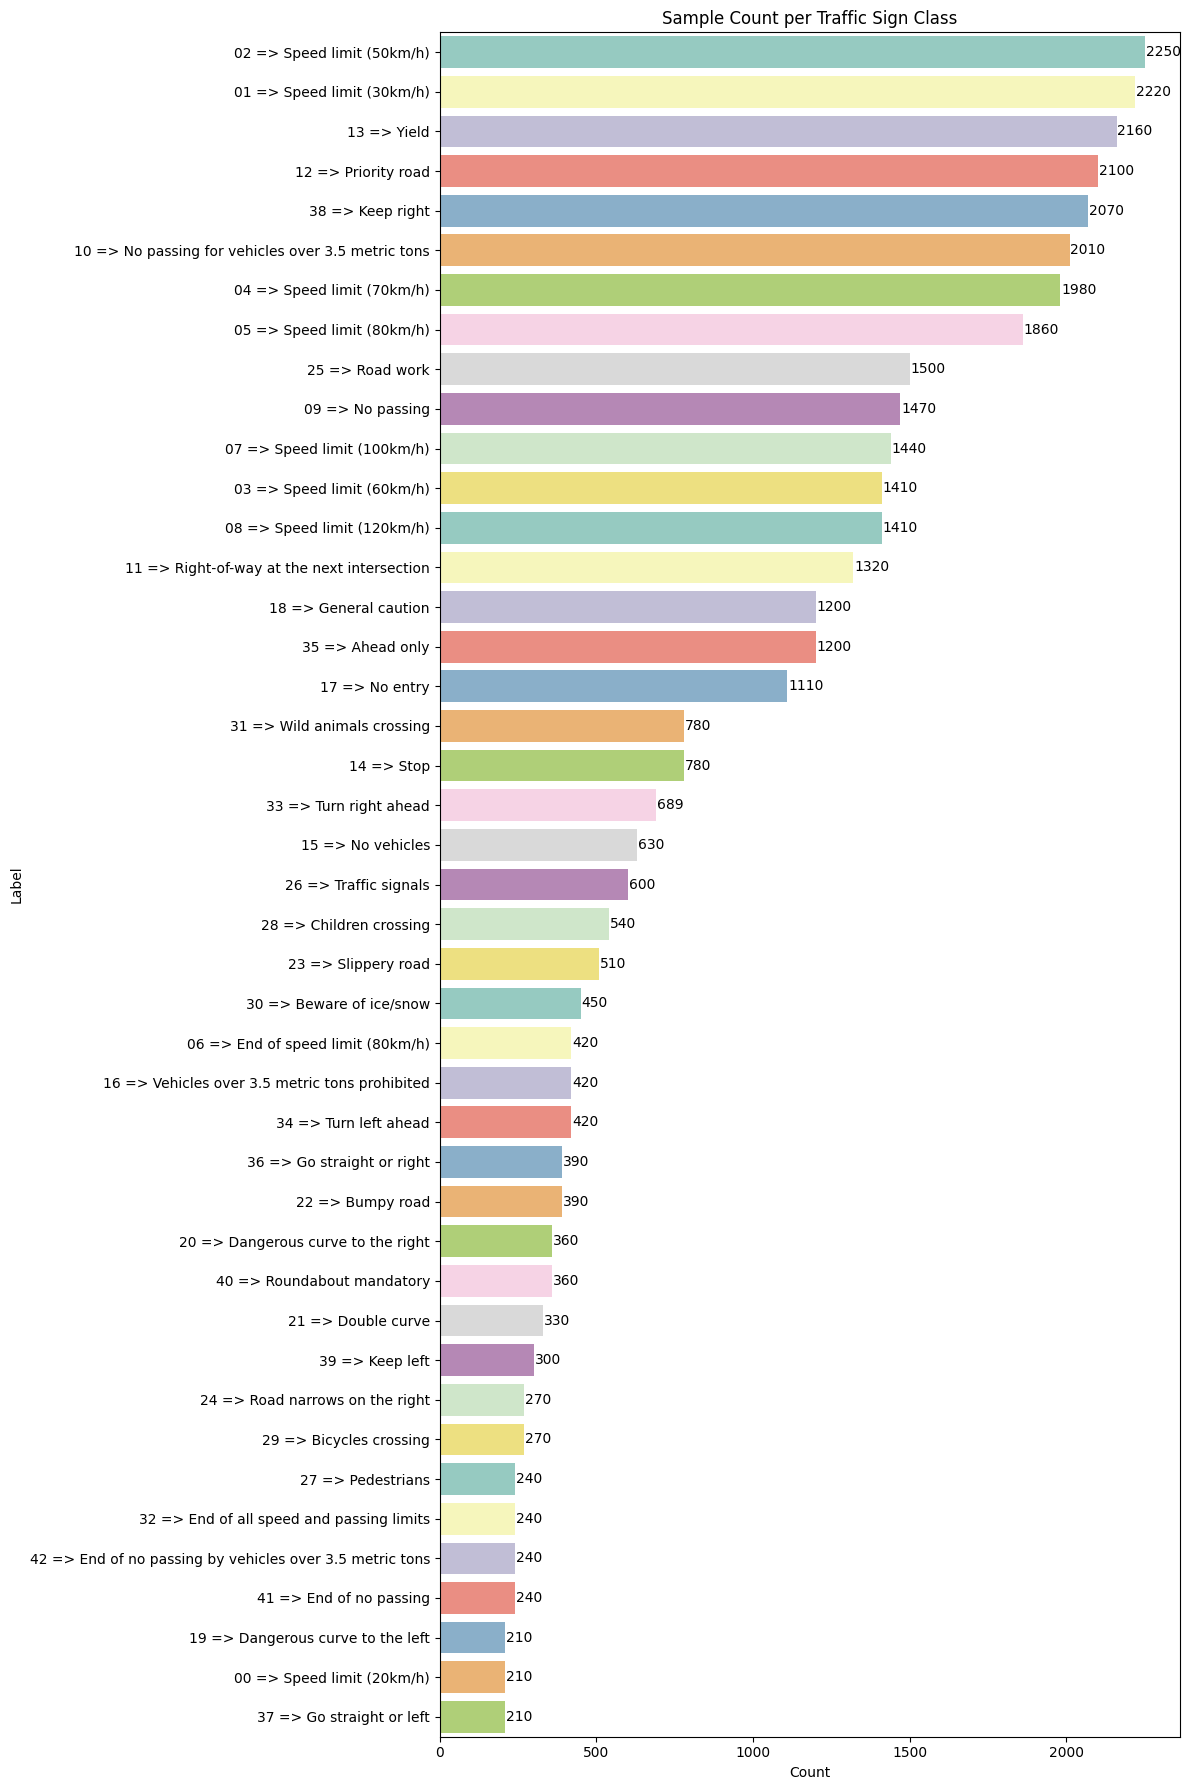

In [7]:
df_sorted = df.sort_values(by = "Count", ascending = False)

# Add labeled column (e.g. "00 => Speed limit (20km")
df_sorted["ClassLabel"] = df_sorted["ClassId"].apply(lambda x: f"{x:02d}") + " => " + df_sorted["Label"]

plt.figure(figsize=(12, 18))
ax = sns.barplot(data = df_sorted, y = "ClassLabel", x = "Count", palette = 'Set3')
plt.title("Sample Count per Traffic Sign Class")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()

# Add count labels to each bar
for i in ax.patches:
    count = int(i.get_width())
    y = i.get_y() + i.get_height() / 2
    ax.text(count + 3, y, str(count), va = 'center')

plt.show()

In [8]:
print("Num labels:", len(labels))

Num labels: 43


In [9]:
# Set variables for later 

data =[]
labels = []
n_classes = len(os.listdir(train_path))
img_size = (32, 32)

In [10]:
# Get image and labels
for i in range(n_classes):
    print(i)
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    
    print(f"Loading images {i:02d}", end = ' ')

    for idx, a in enumerate(images):
        try:
            img_path = os.path.join(path, a)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img = np.array(img)

            data.append(img)
            labels.append(i)

            # Print progress - every 500 imgs
            if idx % 500 == 0:
                print('.', end = '', flush = True)
        except Exception as e:
            print(f"Error loading image: {img_path}")
            print(f"Exception: {e}")

# Convert lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

0
Loading images 00 .1
Loading images 01 .....2
Loading images 02 .....3
Loading images 03 ...4
Loading images 04 ....5
Loading images 05 ....6
Loading images 06 .7
Loading images 07 ...8
Loading images 08 ...9
Loading images 09 ...10
Loading images 10 .....11
Loading images 11 ...12
Loading images 12 .....13
Loading images 13 .....14
Loading images 14 ..15
Loading images 15 ..16
Loading images 16 .17
Loading images 17 ...18
Loading images 18 ...19
Loading images 19 .20
Loading images 20 .21
Loading images 21 .22
Loading images 22 .23
Loading images 23 ..24
Loading images 24 .25
Loading images 25 ...26
Loading images 26 ..27
Loading images 27 .28
Loading images 28 ..29
Loading images 29 .30
Loading images 30 .31
Loading images 31 ..32
Loading images 32 .33
Loading images 33 ..34
Loading images 34 .35
Loading images 35 ...36
Loading images 36 .37
Loading images 37 .38
Loading images 38 .....39
Loading images 39 .40
Loading images 40 .41
Loading images 41 .42
Loading images 42 .

In [11]:
# Check data shape
print("Data size:", data.shape)
print("Labels size:", labels.shape)

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check split data shape
print(f"Train size: [Img: {X_train.shape}, Lbls: {y_train.shape}]")
print(f"Test size: [Img: {X_test.shape}, Lbls: {y_test.shape}]")

Data size: (39209, 32, 32, 3)
Labels size: (39209,)
Train size: [Img: (31367, 32, 32, 3), Lbls: (31367,)]
Test size: [Img: (7842, 32, 32, 3), Lbls: (7842,)]


In [12]:
# Histogram

def draw_hist(dataset, label, num_classes):
    hist, bins = np.histogram(dataset, bins=num_classes)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    plt.bar(center, hist, align = 'center', width = width)
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.show()

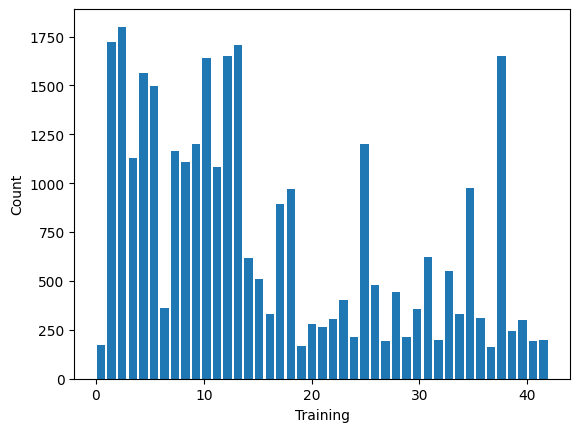

In [13]:
draw_hist(y_train, "Training", n_classes) # 80%

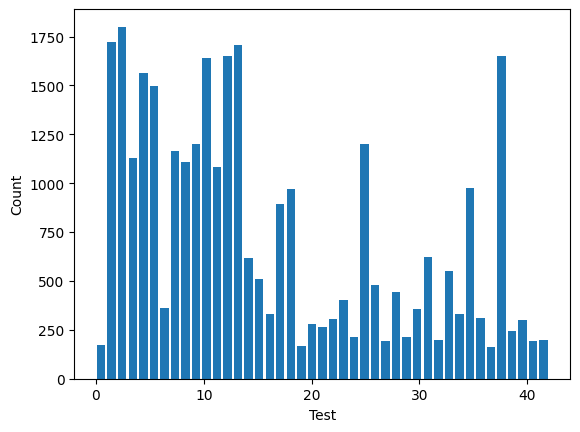

In [14]:
draw_hist(y_train, "Test", n_classes) # 20%

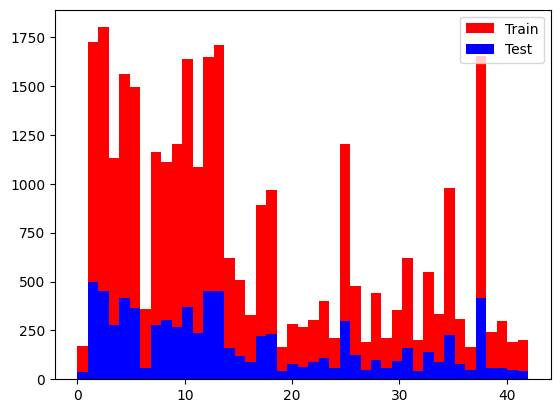

In [15]:
hist, bins = np.histogram(y_train, bins = n_classes)
plt.hist(y_train, bins, color = 'red', label = 'Train')
plt.hist(y_test, bins, color = 'blue', label = 'Test')
plt.legend(loc = 'upper right')
plt.show()

In [16]:
# Display grid
def display_grid(imgs, lbls, cmap = ''):
    fig, axes = plt.subplots(10, 10, figsize = (20, 22))

    for i, ax in enumerate(axes.flat):
        r = np.random.randint(imgs.shape[0])
        class_id = lbls[r]
        label_str = class_labels.get(class_id, "Unknown")

        if cmap !='':
            ax.imshow(imgs[r].astype('uint8'), cmap = cmap)
        else:
            ax.imshow(imgs[r].astype('uint8'))
        ax.grid(False)
        ax.axis('off')

        ax.set_title(f'Label: {class_id}\n{label_str}', fontsize = 12, loc = 'center')
    plt.subplots_adjust(hspace = 0.4) #Add space
    plt.show()

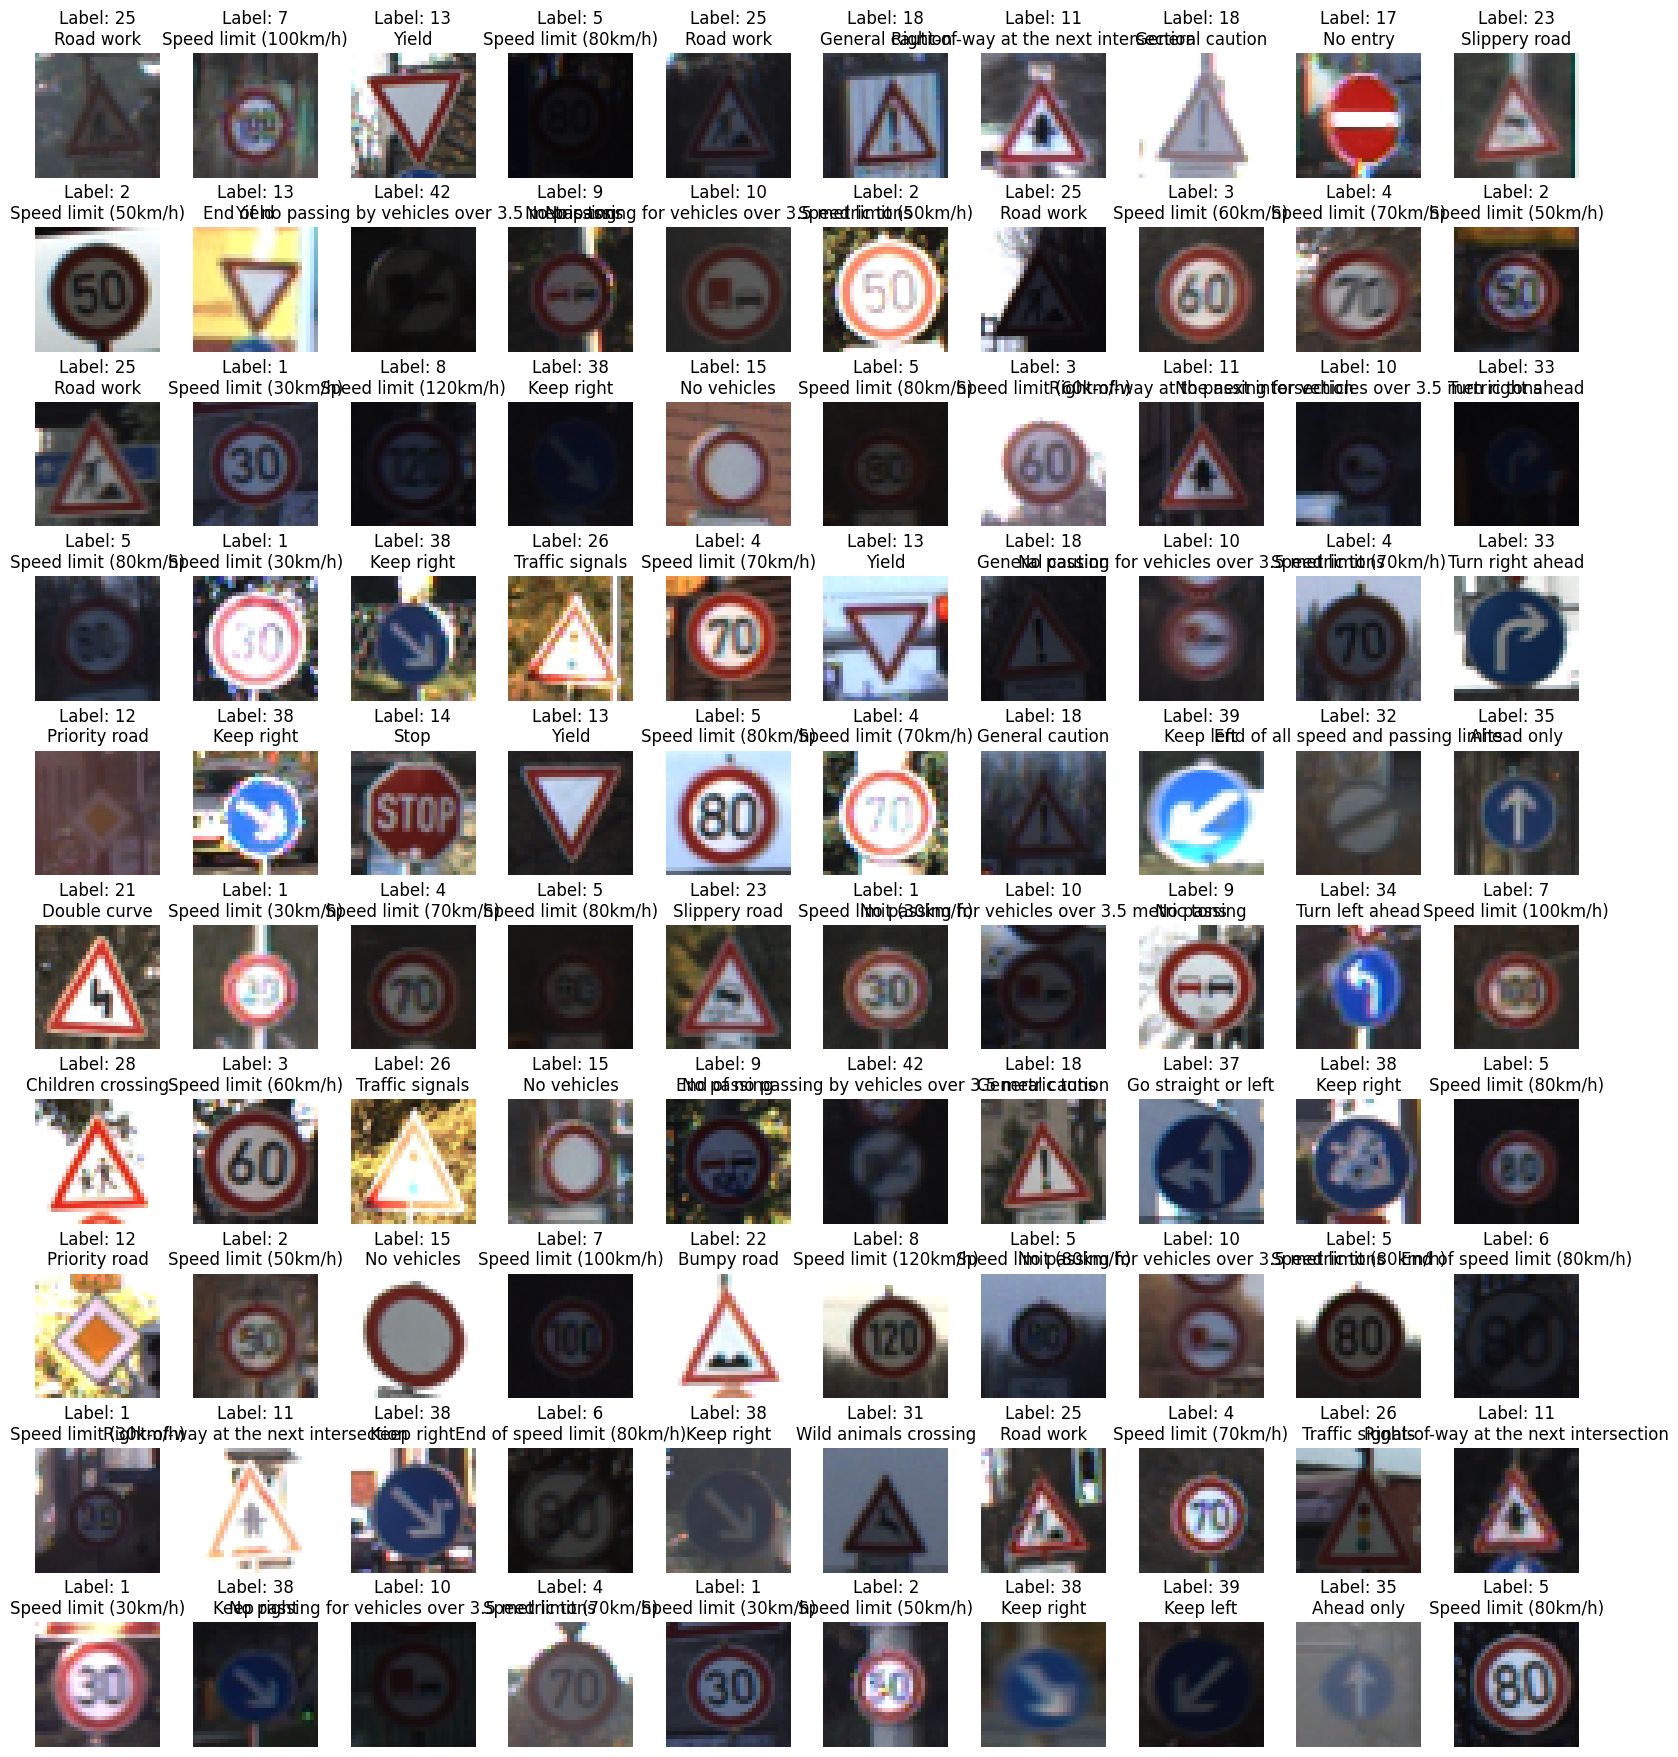

In [17]:
display_grid(X_train,y_train)

In [18]:
def gray_scale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [19]:
def normalize_image(image):
    # return ((img - np.mean(img)) / np.std(img)) # Z-score norm
    return img / 255.0 #[0, 1]

In [20]:
def equalize(img):
    return cv2.equalizeHist(img)

In [21]:
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

In [22]:
from sklearn.utils import shuffle

In [23]:
def preprocess(imgs, lbls):
    # Run functions
    gray = list(map(gray_scale_image, imgs))
    eq = list(map(equalize, gray))
    # pre = list(map(normalize_image, eq))

    # Convert to numpy arrays
    x_imgs = np.array(eq)
    y_lbls = np.array(lbls)

    x_imgs, y_lbls = shuffle(x_imgs,y_lbls)
    return x_imgs, y_lbls

In [24]:
X_train_preprocessed, y_train_preprocessed = preprocess(X_train, y_train)

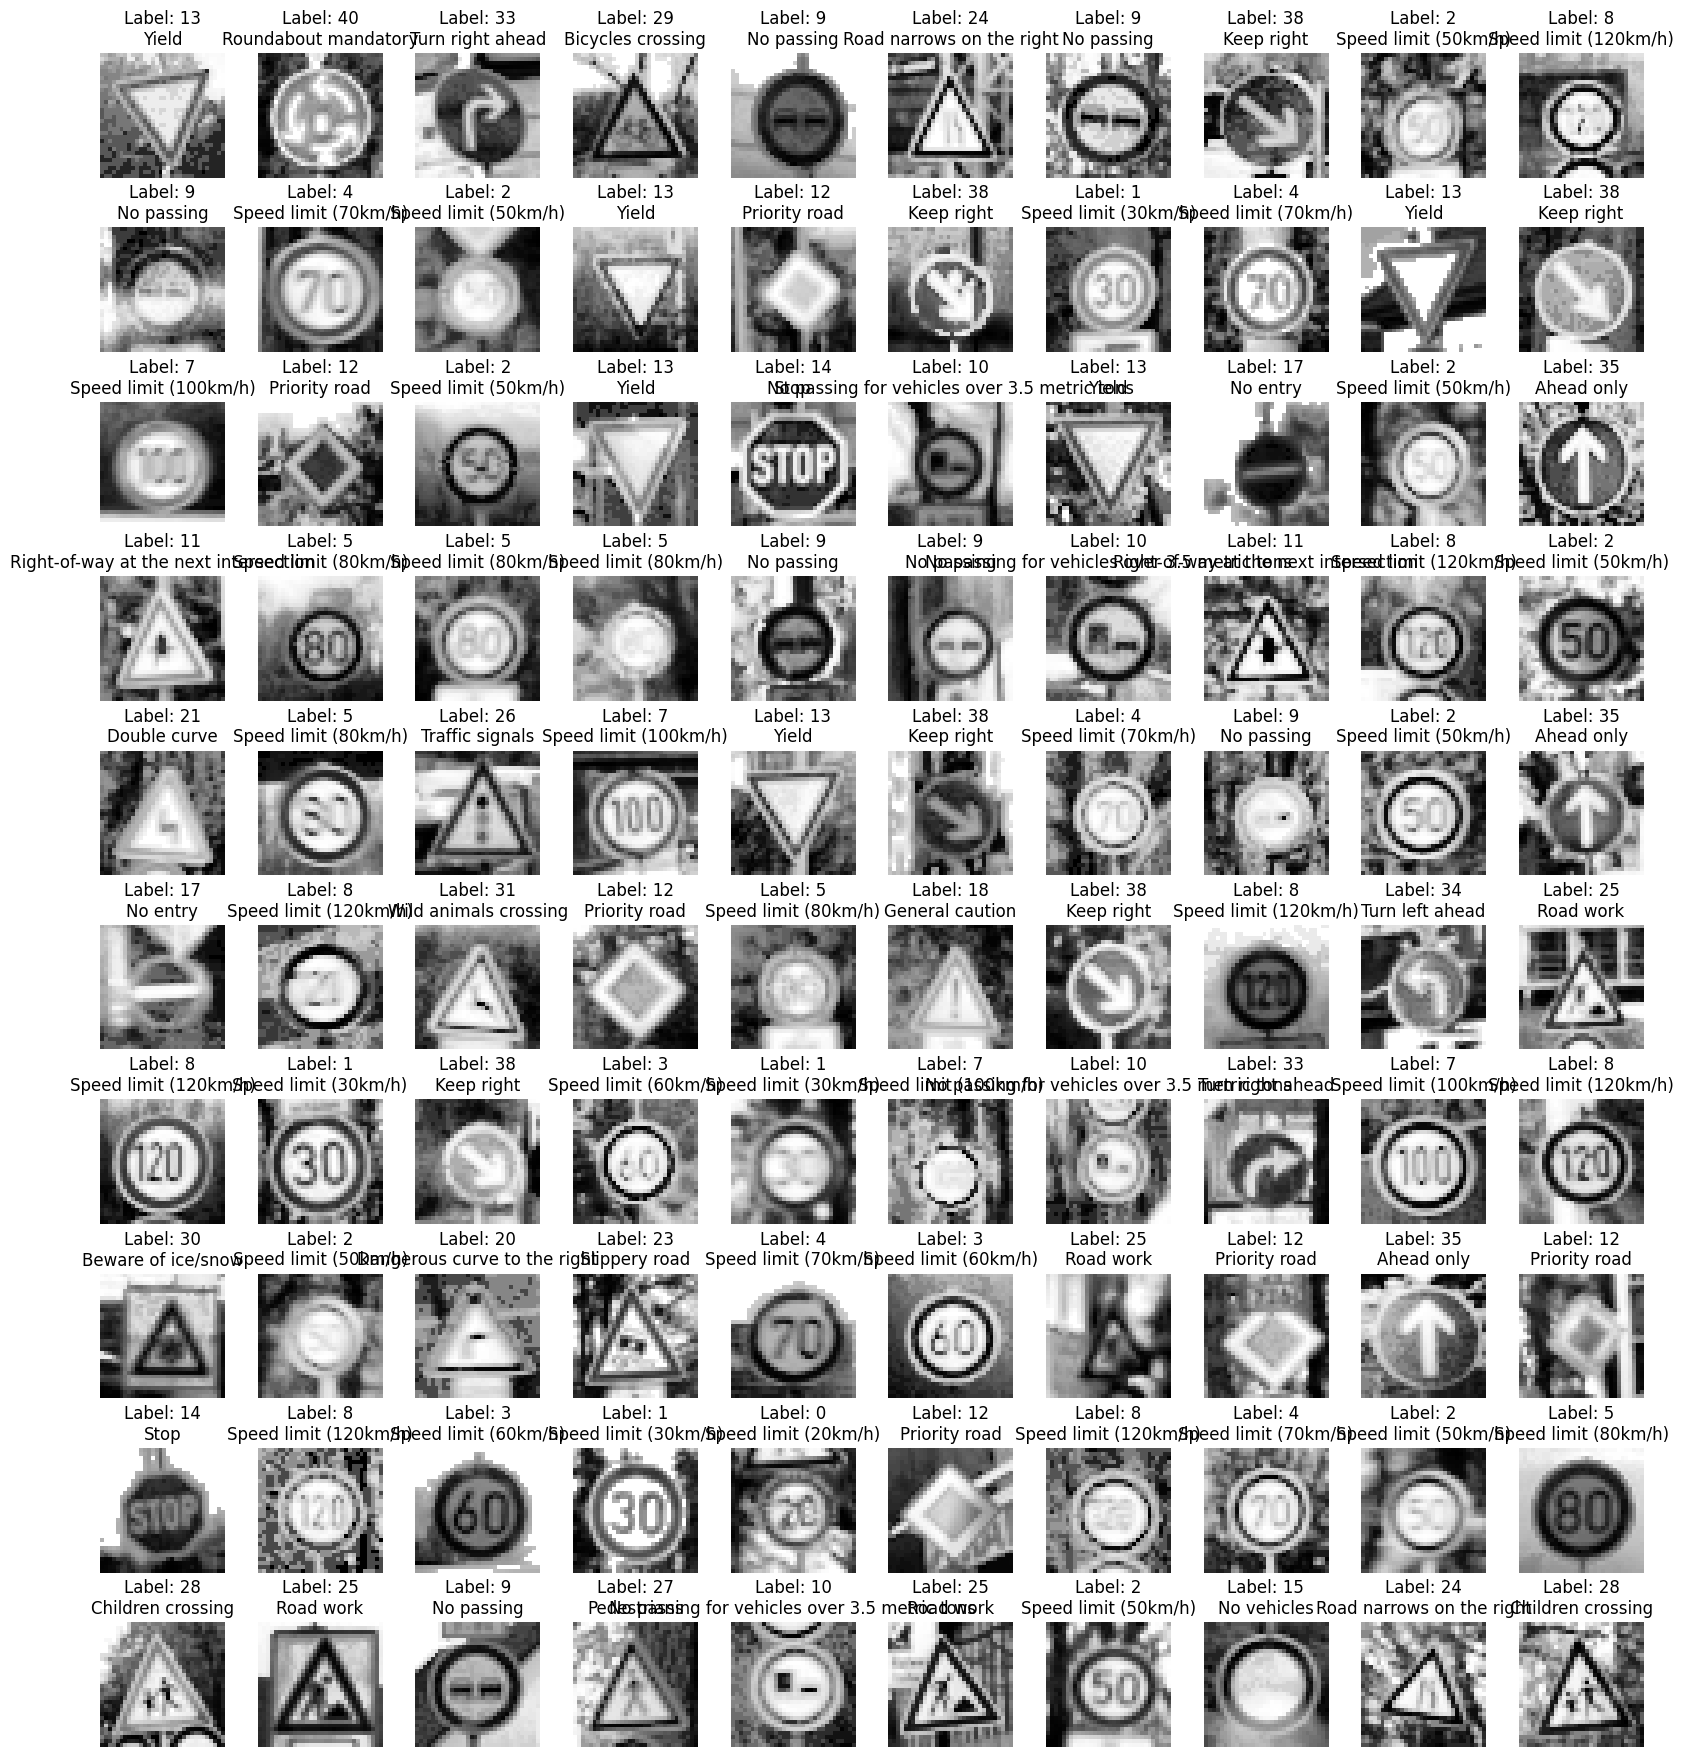

In [25]:
display_grid(X_train_preprocessed, y_train_preprocessed, cmap = 'gray')

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     Flatten, Dense)

def build_model(input_shape=(32, 32, 1), num_classes=43):  # Set num_classes as per your dataset
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [27]:
model = build_model(input_shape=(32, 32, 1), num_classes=n_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751384694.515798      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [28]:
model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer='adam',
    metrics=['accuracy']
)
# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,357,579 (5.18 MB)

 Trainable params: 1,357,579 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

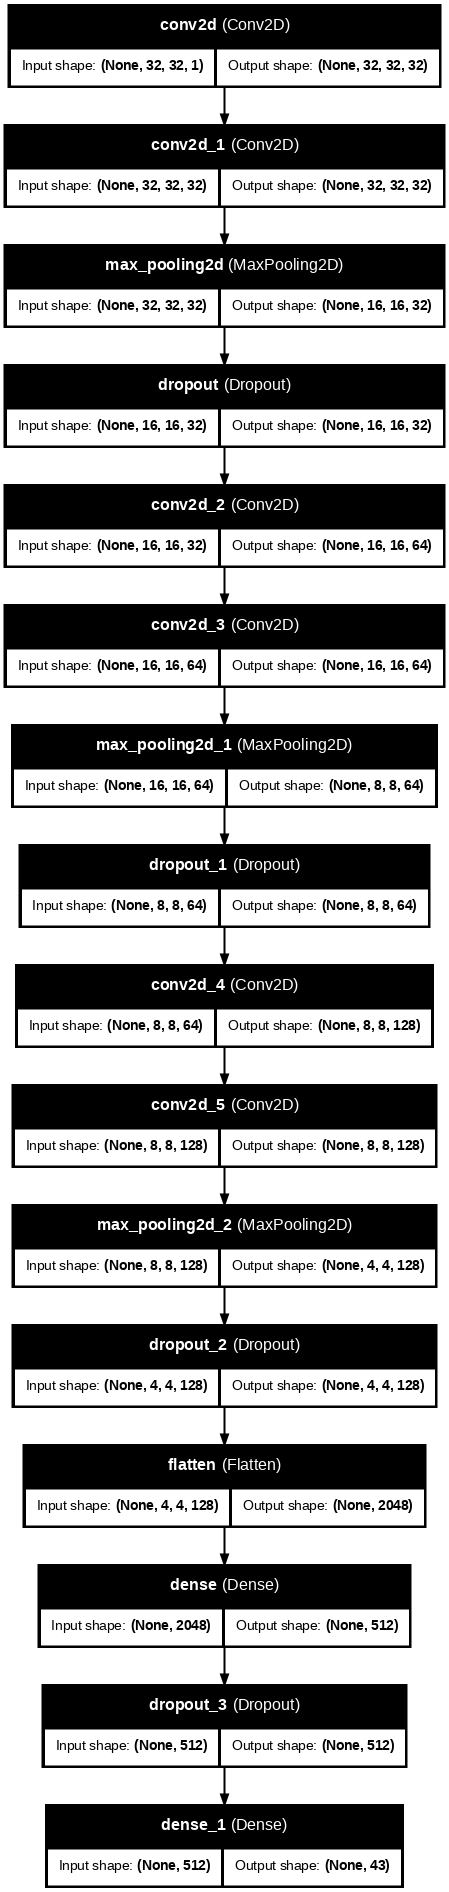

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(
    model, show_layer_names=True, show_shapes=True, to_file='simple_model.png', dpi=72
)

In [30]:
# Preprocess test data
X_test_preprocessed, y_test_preprocessed = preprocess(X_test, y_test)

# Reshape for CNN (add channel dimension)
X_train_ready = X_train_preprocessed.reshape(-1, 32, 32, 1)
X_test_ready = X_test_preprocessed.reshape(-1, 32, 32, 1)

# Normalize pixel values
X_train_ready = X_train_ready.astype('float32') / 255.0
X_test_ready = X_test_ready.astype('float32') / 255.0

In [31]:
n_epochs = 100
batch_size = 128

# Make sure these callbacks are defined earlier in your code
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

model_check = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
csv_logger = CSVLogger('training_log.csv')

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
    X_train_ready, y_train_preprocessed,
    batch_size=128,
    epochs=40,
    validation_data=(X_test_ready, y_test_preprocessed),
    callbacks=[model_check, early, reduce_lr, csv_logger]
)

Epoch 1/40


I0000 00:00:1751384700.077700      98 service.cc:148] XLA service 0x79fdc80045f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751384700.078503      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751384700.502719      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 21/246 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0515 - loss: 3.6199

I0000 00:00:1751384705.177543      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.1741 - loss: 3.0651 - val_accuracy: 0.8489 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 2/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8318 - loss: 0.5295 - val_accuracy: 0.9551 - val_loss: 0.1397 - learning_rate: 0.0010
Epoch 3/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9270 - loss: 0.2319 - val_accuracy: 0.9750 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 4/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9554 - loss: 0.1424 - val_accuracy: 0.9841 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9671 - loss: 0.1008 - val_accuracy: 0.9907 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 6/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9779 - loss: 0.0670 - val_accuracy: 0.9866 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 7/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9702 - loss: 0.0899 - val_accur

In [32]:
# Save the Model
model.save('bestmodel.h5')

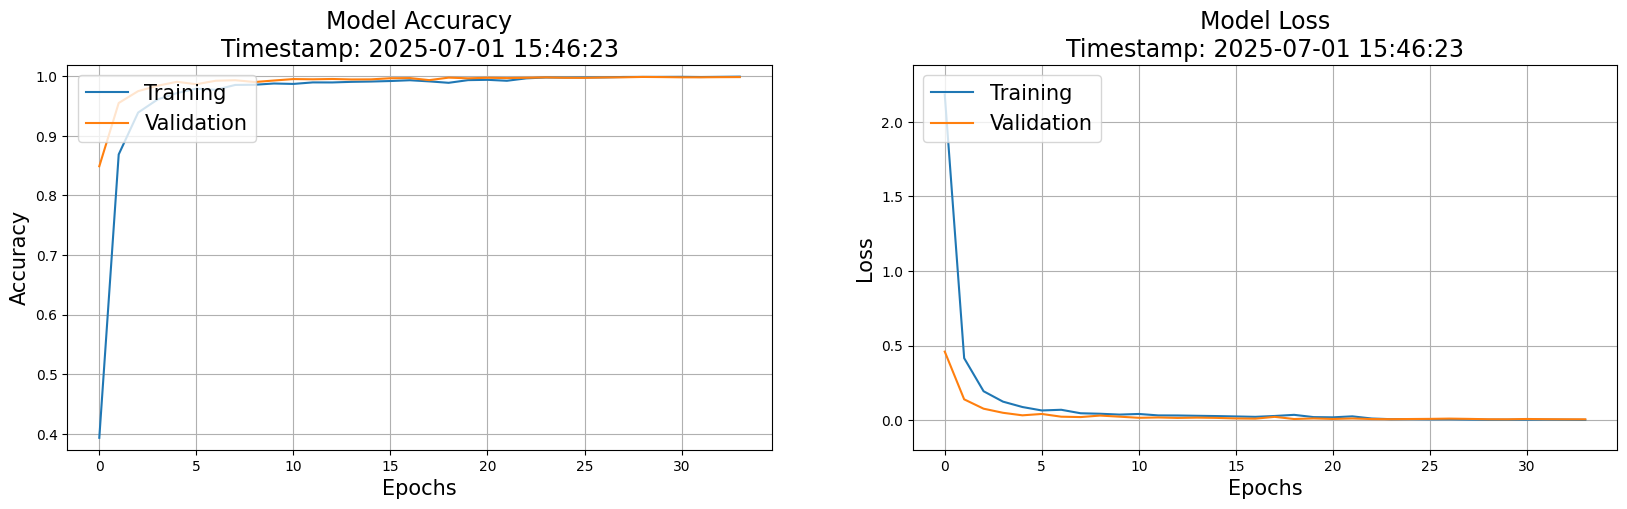

In [33]:
# Plot training
performance_plot(history=history, figure_directory='.', ylim_pad=[0.02, 0.2])


In [34]:
# Load model
model = load_model("bestmodel.h5")
print("Model input shape:", model.input_shape)

Model input shape: (None, 32, 32, 1)


In [35]:
import os
test_dir = '/kaggle/input/gtsrb-german-traffic-sign/Test'
print(f"Test directory exists: {os.path.exists(test_dir)}")

Test directory exists: True


In [36]:
if os.path.exists(test_dir):
    files = os.listdir(test_dir)
    print(f"Number of files in test directory: {len(files)}")
    print(f"First 10 files: {files[:10]}")
else:
    # Check what directories are available
    base_path = '/kaggle/input/gtsrb-german-traffic-sign/'
    print("Available directories:")
    for item in os.listdir(base_path):
        print(f"  {item}")

Number of files in test directory: 12631
First 10 files: ['01301.png', '02578.png', '06781.png', '11396.png', '00929.png', '04915.png', '07470.png', '08216.png', '12329.png', '02630.png']


In [37]:
def predict_traffic_signs(test_dir, model, img_size=(32, 32), batch_size=128):
    """
    Load test images, preprocess them consistently with training data,
    and make predictions
    """
    # Load images
    list_of_imgs = []
    image_names = []
    
    print("Loading test images...")
    for idx, image_name in enumerate(os.listdir(test_dir)):
        img_path = os.path.join(test_dir, image_name)
        img = cv2.imread(img_path)
        
        # Check if image is read properly
        if img is None:
            print(f"Warning: Couldn't read {image_name}")
            continue
            
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, img_size)
        
        list_of_imgs.append(img)
        image_names.append(image_name)
        
        # Print progress every 1000 images
        if idx % 1000 == 0:
            print(f"Loaded {idx} images...")
    
    print(f"Total images loaded: {len(list_of_imgs)}")
    
    # Apply the SAME preprocessing as training
    print("Preprocessing images...")
    
    # 1. Convert to grayscale
    gray_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in list_of_imgs]
    
    # 2. Apply histogram equalization (same as training)
    eq_imgs = [cv2.equalizeHist(img) for img in gray_imgs]
    
    # 3. Convert to numpy array and reshape for CNN
    X_test = np.array(eq_imgs)
    X_test = X_test.reshape(-1, 32, 32, 1)  # Add channel dimension
    
    # 4. Normalize (same as training)
    X_test = X_test.astype('float32') / 255.0
    
    print(f"Final test data shape: {X_test.shape}")
    
    # Make predictions
    print("Making predictions...")
    predictions = model.predict(X_test, batch_size=batch_size, verbose=1)
    
    # Get predicted class IDs
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get confidence scores
    confidence_scores = np.max(predictions, axis=1)
    
    return predictions, predicted_classes, confidence_scores, image_names


In [38]:
def get_top_k_predictions(predictions, k=5):
    """Get top k predictions for each image"""
    # Get top k indices for each prediction
    top_k_indices = np.argsort(predictions, axis=1)[:, -k:][:, ::-1]
    
    # Get corresponding probabilities
    top_k_probs = np.take_along_axis(predictions, top_k_indices, axis=1)
    
    return top_k_indices, top_k_probs

In [39]:
def display_predictions(image_names, predicted_classes, confidence_scores, 
                       class_labels, num_display=10):
    """Display prediction results"""
    print(f"\nTop {num_display} Predictions:")
    print("-" * 80)
    print(f"{'Image Name':<25} | {'Class':<5} | {'Confidence':<10} | {'Label'}")
    print("-" * 80)
    
    for i in range(min(num_display, len(image_names))):
        class_id = predicted_classes[i]
        confidence = confidence_scores[i]
        label = class_labels.get(class_id, f"Unknown_{class_id}")
        
        print(f"{image_names[i]:<25} | {class_id:<5} | {confidence:<10.3f} | {label}")

In [40]:
# Make sure test directory path is correct
test_dir = '/kaggle/input/gtsrb-german-traffic-sign/Test'

# Run predictions
try:
    predictions, predicted_classes, confidence_scores, image_names = predict_traffic_signs(
        test_dir, model, img_size=(32, 32), batch_size=128
    )
    print("Predictions completed successfully!")
    
except Exception as e:
    print(f"Error during prediction: {e}")
    print("Please check if the test directory path is correct")


Loading test images...
Loaded 0 images...
Loaded 1000 images...
Loaded 2000 images...
Loaded 3000 images...
Loaded 4000 images...
Loaded 5000 images...
Loaded 6000 images...
Loaded 7000 images...
Loaded 8000 images...
Loaded 9000 images...
Loaded 10000 images...
Loaded 11000 images...
Loaded 12000 images...
Total images loaded: 12630
Preprocessing images...
Final test data shape: (12630, 32, 32, 1)
Making predictions...
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Predictions completed successfully!


In [41]:
if 'predictions' in locals():
    # Display basic statistics
    print(f"\nPrediction Summary:")
    print(f"Total images processed: {len(image_names)}")
    print(f"Average confidence: {np.mean(confidence_scores):.3f}")
    print(f"Min confidence: {np.min(confidence_scores):.3f}")
    print(f"Max confidence: {np.max(confidence_scores):.3f}")
    
    # Display top predictions
    display_predictions(image_names, predicted_classes, confidence_scores, 
                       class_labels, num_display=20)



Prediction Summary:
Total images processed: 12630
Average confidence: 0.989
Min confidence: 0.183
Max confidence: 1.000

Top 20 Predictions:
--------------------------------------------------------------------------------
Image Name                | Class | Confidence | Label
--------------------------------------------------------------------------------
01301.png                 | 18    | 1.000      | General caution
02578.png                 | 22    | 1.000      | Bumpy road
06781.png                 | 38    | 1.000      | Keep right
11396.png                 | 11    | 1.000      | Right-of-way at the next intersection
00929.png                 | 17    | 1.000      | No entry
04915.png                 | 8     | 1.000      | Speed limit (120km/h)
07470.png                 | 3     | 1.000      | Speed limit (60km/h)
08216.png                 | 12    | 1.000      | Priority road
12329.png                 | 20    | 1.000      | Dangerous curve to the right
02630.png                 | 7

In [42]:
if 'predictions' in locals():
    # Get top-5 predictions for detailed analysis
    top_5_indices, top_5_probs = get_top_k_predictions(predictions, k=5)
    
    print(f"\nTop-5 Analysis for first 5 images:")
    print("-" * 60)
    
    for i in range(min(5, len(image_names))):
        print(f"\nImage: {image_names[i]}")
        print("Top 5 predictions:")
        for j in range(5):
            class_id = top_5_indices[i][j]
            prob = top_5_probs[i][j]
            label = class_labels.get(class_id, f"Unknown_{class_id}")
            print(f"  {j+1}. Class {class_id:2d}: {prob:.3f} - {label}")


Top-5 Analysis for first 5 images:
------------------------------------------------------------

Image: 01301.png
Top 5 predictions:
  1. Class 18: 1.000 - General caution
  2. Class 26: 0.000 - Traffic signals
  3. Class 27: 0.000 - Pedestrians
  4. Class 32: 0.000 - End of all speed and passing limits
  5. Class 24: 0.000 - Road narrows on the right

Image: 02578.png
Top 5 predictions:
  1. Class 22: 1.000 - Bumpy road
  2. Class 26: 0.000 - Traffic signals
  3. Class 25: 0.000 - Road work
  4. Class 38: 0.000 - Keep right
  5. Class 29: 0.000 - Bicycles crossing

Image: 06781.png
Top 5 predictions:
  1. Class 38: 1.000 - Keep right
  2. Class 10: 0.000 - No passing for vehicles over 3.5 metric tons
  3. Class  5: 0.000 - Speed limit (80km/h)
  4. Class 36: 0.000 - Go straight or right
  5. Class 30: 0.000 - Beware of ice/snow

Image: 11396.png
Top 5 predictions:
  1. Class 11: 1.000 - Right-of-way at the next intersection
  2. Class 42: 0.000 - End of no passing by vehicles over 3.

In [43]:
def visualize_predictions(test_dir, image_names, predicted_classes, confidence_scores, 
                         class_labels, num_images=9):
    """Visualize predictions with images"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(image_names))):
        # Load and display image
        img_path = os.path.join(test_dir, image_names[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Add prediction info as title
        class_id = predicted_classes[i]
        confidence = confidence_scores[i]
        label = class_labels.get(class_id, f"Unknown_{class_id}")
        
        title = f"Pred: {class_id} ({confidence:.2f})\n{label}"
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()


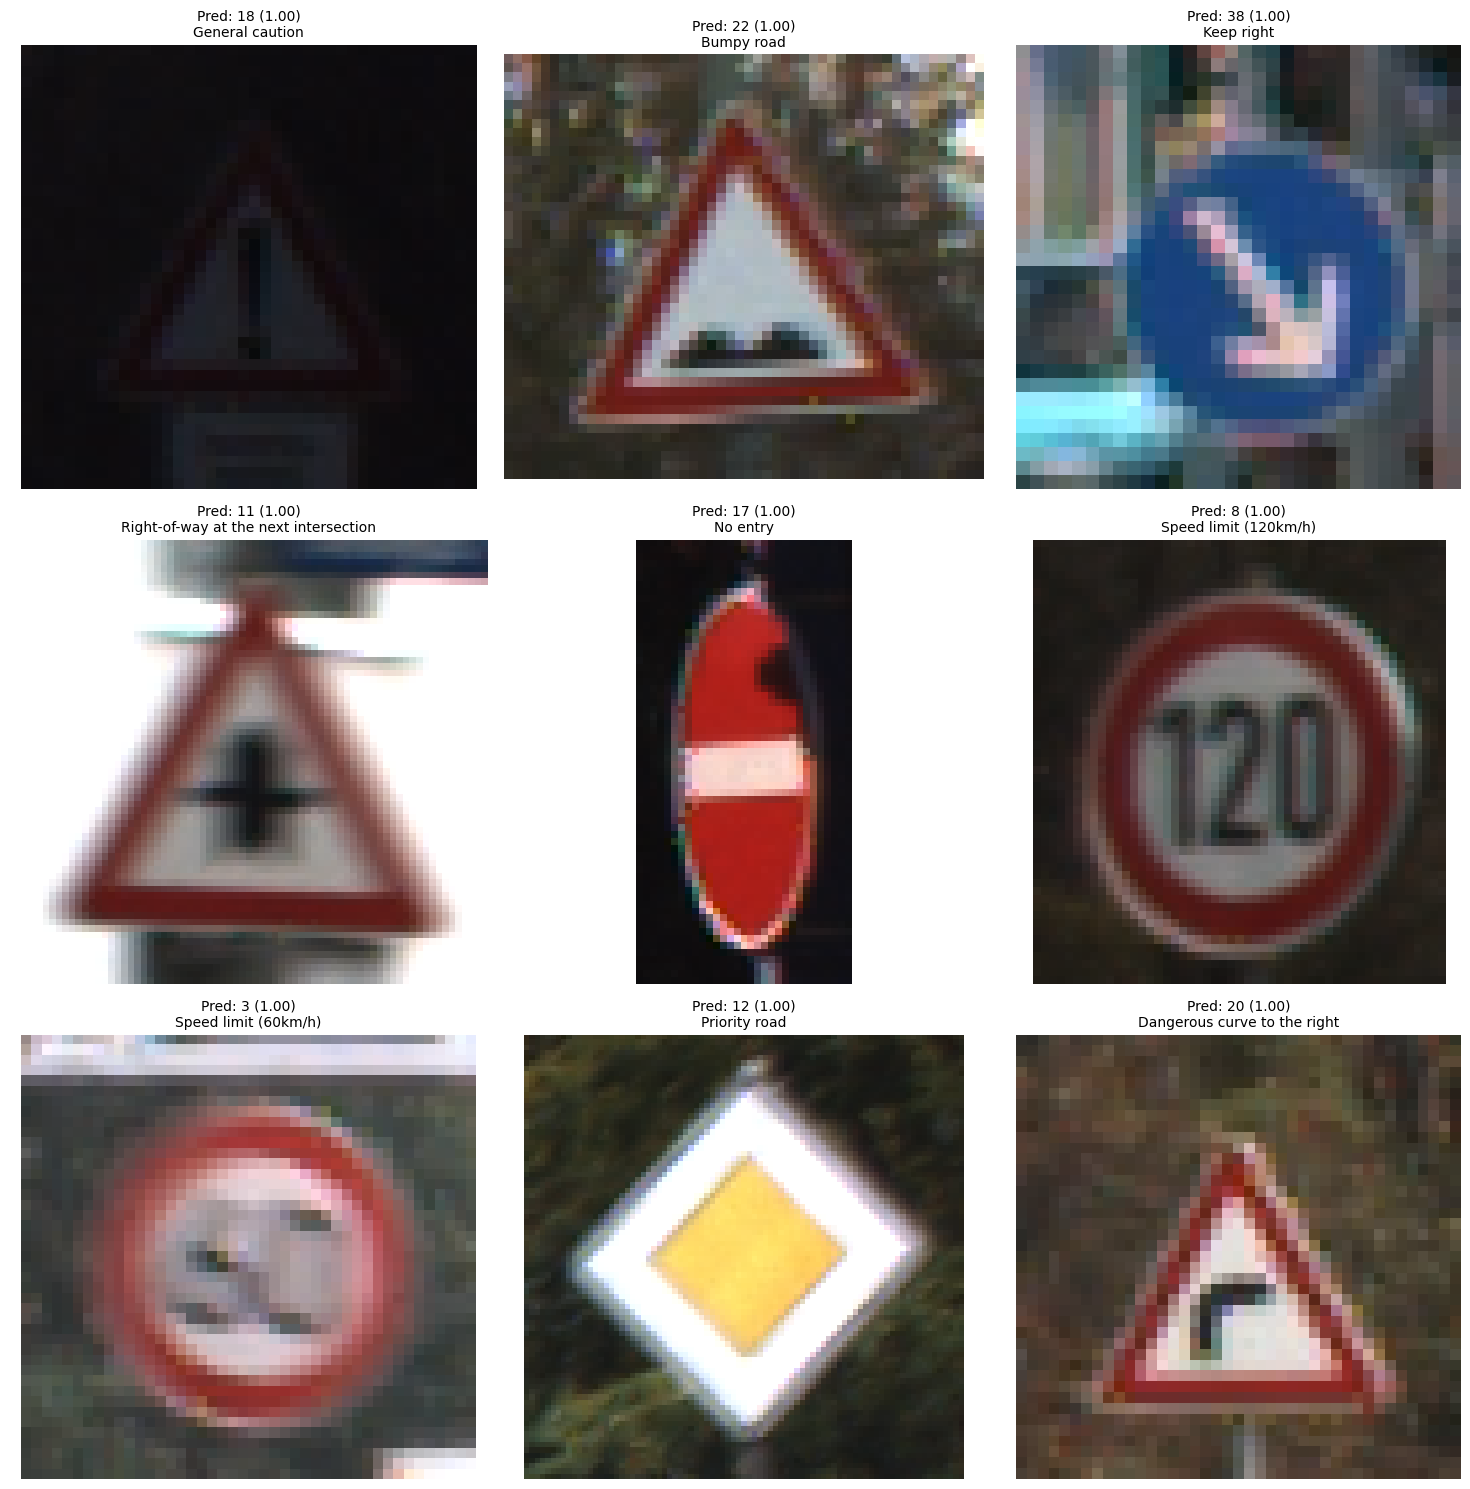

Predictions saved to 'traffic_sign_predictions.csv'
Results preview:
  image_name  predicted_class  confidence  \
0  01301.png               18    1.000000   
1  02578.png               22    1.000000   
2  06781.png               38    1.000000   
3  11396.png               11    1.000000   
4  00929.png               17    1.000000   
5  04915.png                8    1.000000   
6  07470.png                3    1.000000   
7  08216.png               12    1.000000   
8  12329.png               20    1.000000   
9  02630.png                7    0.999942   

                         predicted_label  
0                        General caution  
1                             Bumpy road  
2                             Keep right  
3  Right-of-way at the next intersection  
4                               No entry  
5                  Speed limit (120km/h)  
6                   Speed limit (60km/h)  
7                          Priority road  
8           Dangerous curve to the right  
9    

In [44]:
# Run visualization
if 'predictions' in locals():
    visualize_predictions(test_dir, image_names, predicted_classes, 
                         confidence_scores, class_labels, num_images=9)

# CELL 11: Save Predictions to CSV
if 'predictions' in locals():
    # Create results dataframe
    results_df = pd.DataFrame({
        'image_name': image_names,
        'predicted_class': predicted_classes,
        'confidence': confidence_scores,
        'predicted_label': [class_labels.get(cls, f"Unknown_{cls}") for cls in predicted_classes]
    })
    
    # Save to CSV
    results_df.to_csv('traffic_sign_predictions.csv', index=False)
    print("Predictions saved to 'traffic_sign_predictions.csv'")
    print(f"Results preview:")
    print(results_df.head(10))


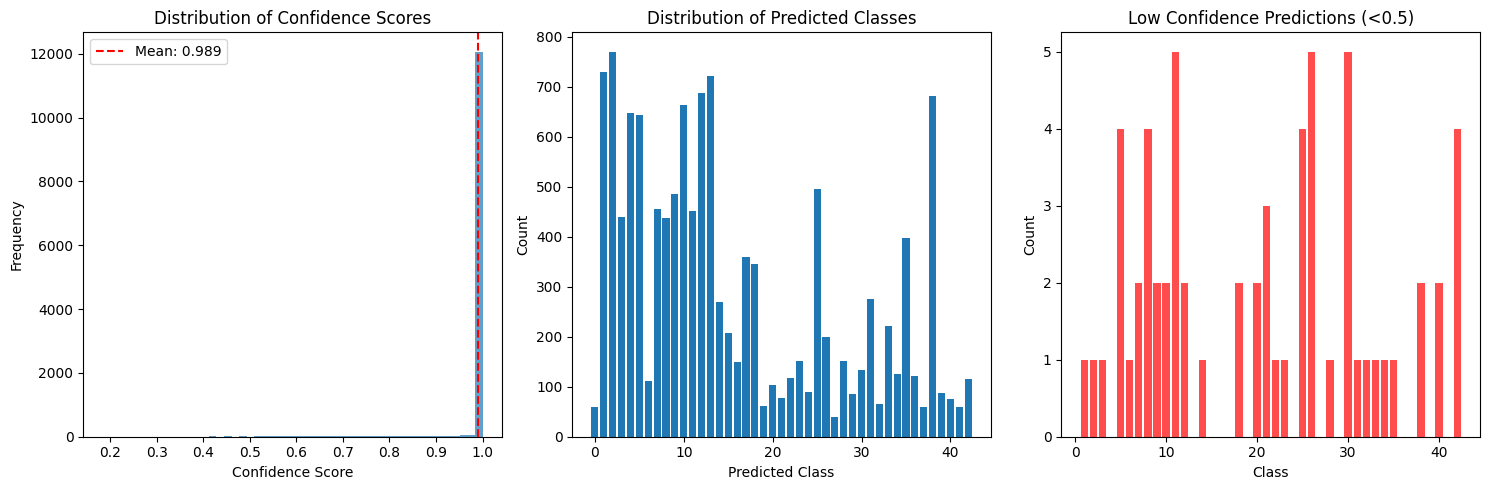

Low confidence predictions: 63 out of 12630


In [45]:
if 'predictions' in locals():
    # Analyze prediction distribution
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Confidence distribution
    plt.subplot(1, 3, 1)
    plt.hist(confidence_scores, bins=50, alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Confidence Scores')
    plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                label=f'Mean: {np.mean(confidence_scores):.3f}')
    plt.legend()
    
    # Subplot 2: Class prediction distribution
    plt.subplot(1, 3, 2)
    unique_classes, counts = np.unique(predicted_classes, return_counts=True)
    plt.bar(unique_classes, counts)
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Classes')
    
    # Subplot 3: Low confidence predictions
    plt.subplot(1, 3, 3)
    low_conf_threshold = 0.5
    low_conf_mask = confidence_scores < low_conf_threshold
    low_conf_classes = predicted_classes[low_conf_mask]
    
    if len(low_conf_classes) > 0:
        unique_low, counts_low = np.unique(low_conf_classes, return_counts=True)
        plt.bar(unique_low, counts_low, color='red', alpha=0.7)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title(f'Low Confidence Predictions (<{low_conf_threshold})')
    else:
        plt.text(0.5, 0.5, 'No low confidence predictions', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Low Confidence Predictions (<{low_conf_threshold})')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Low confidence predictions: {np.sum(low_conf_mask)} out of {len(confidence_scores)}")

METHOD 1: Using your train/test split data
--------------------------------------------------
Test Loss: 0.0063
Test Accuracy: 0.9989 (99.89%)

Detailed Classification Report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.97      1.00      0.99        38
                              Speed limit (30km/h)       1.00      1.00      1.00       496
                              Speed limit (50km/h)       1.00      1.00      1.00       450
                              Speed limit (60km/h)       1.00      1.00      1.00       280
                              Speed limit (70km/h)       1.00      1.00      1.00       418
                              Speed limit (80km/h)       1.00      1.00      1.00       364
                       End of speed limit (80km/h)       1.00      1.00      1.00        59
                             Speed limit (100km/h)       1.00      1.00      1.00      

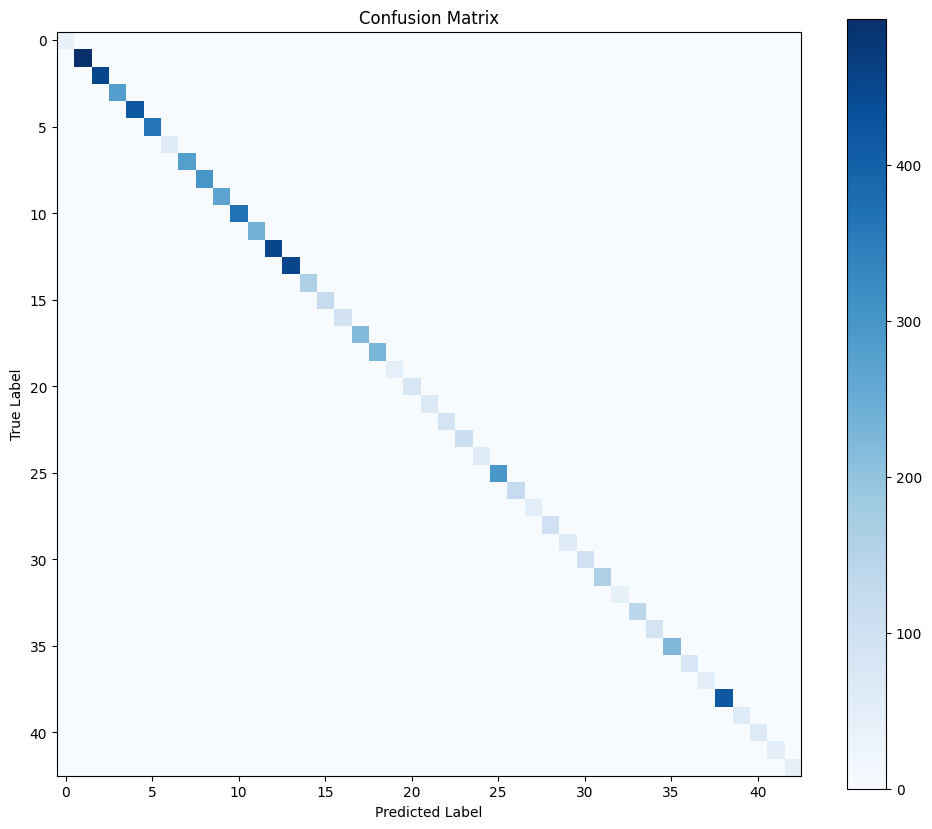

In [46]:
# METHOD 1: If you have X_test_ready and y_test_preprocessed from your train/test split
# This is the EASIEST method since you already have the test data from your split

if 'X_test_ready' in locals() and 'y_test_preprocessed' in locals():
    print("METHOD 1: Using your train/test split data")
    print("-" * 50)
    
    # Calculate accuracy on your held-out test set
    test_loss, test_accuracy = model.evaluate(X_test_ready, y_test_preprocessed, verbose=0)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Get detailed predictions for analysis
    test_predictions = model.predict(X_test_ready, verbose=0)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    
    # Additional metrics
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test_preprocessed, test_pred_classes, 
                              target_names=[class_labels[i] for i in range(len(class_labels))]))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_preprocessed, test_pred_classes)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

else:
    print("X_test_ready or y_test_preprocessed not found. Using alternative methods...")
